<a href="https://colab.research.google.com/github/149189/Experiments_on_Food101_dataset/blob/main/Model_4_on_Food_101_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import zipfile
from pathlib import Path

In [2]:


!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-20 10:10:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-20 10:10:55 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2024-08-20 10:10:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  13.7MB/s    in 42s     

2024-08-20 10:11:38 (11.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [5]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32
)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.1),
    layers.RandomWidth(0.1),
], name="data_augmentation")

In [8]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [10]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model = models.Model(inputs, outputs)

In [11]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    metrics=["accuracy"]
)

In [12]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fine_tuning")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("fine_tuned_model.keras", save_best_only=True)

In [13]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 153s 440ms/step - accuracy: 0.4059 - loss: 1.7792 - val_accuracy: 0.8487 - val_loss: 0.4647
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 97s 413ms/step - accuracy: 0.7823 - loss: 0.6944 - val_accuracy: 0.8273 - val_loss: 0.4912
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 139s 401ms/step - accuracy: 0.8453 - loss: 0.4982 - val_accuracy: 0.8355 - val_loss: 0.5098
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 140s 392ms/step - accuracy: 0.8729 - loss: 0.4162 - val_accuracy: 0.8454 - val_loss: 0.4764
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8858 - loss: 0.3613

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


235/235 ━━━━━━━━━━━━━━━━━━━━ 181s 561ms/step - accuracy: 0.8859 - loss: 0.3612 - val_accuracy: 0.7941 - val_loss: 0.5426


In [14]:
results_fine_Tuned_model = model.evaluate(test_data)
results_fine_Tuned_model

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8410 - loss: 0.4571


[0.4569302201271057, 0.8460000157356262]

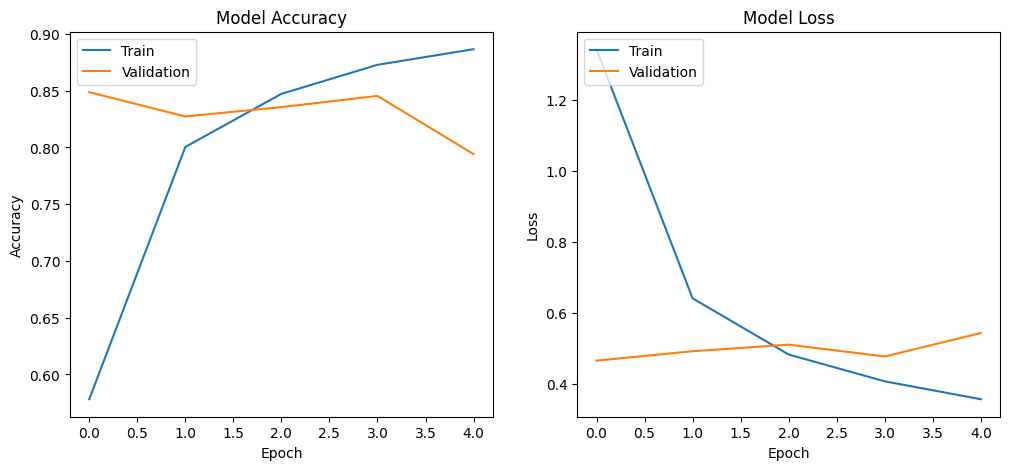

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.show()
